Read EEG data from xdf files, find event markers, pre-process data, extract epochs and run the classification for Present/Absent. We use data from the first session as training set and from the second session as testing set.

In [2]:
import pyxdf
import numpy as np
import bisect
from pathlib import Path
import collections
import matplotlib.pyplot as plt
import scipy.signal as signal

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import pickle

Rutinas auxiliares / Auxiliary routines

In [3]:
# Find timestamps that are the best match
def locate_pos(available_ts, target_ts):
    """Finds best fitting time point.
    
    Parameters
    ----------
    available_ts: array of floats 
        Time stamps of time series
    target_ts: float
        Time stamp that should be found in list of time stamps

    Returns
    ----------
    pos: integer 
        index of time stamp with smallest distance from target_ts
    """
    pos = bisect.bisect_left(available_ts, target_ts)
    if pos == 0:
        return 0
    if pos == len(available_ts):
        return len(available_ts)-1
    if abs(available_ts[pos]-target_ts) < abs(available_ts[pos-1]-target_ts):
        return pos
    else:
        return pos-1  

In [4]:
def load_synchronized_eeg_from_xdf(filename, eeg_stream_label='actiCHamp-21070611', marker_stream_label='EEGPilotMarkerStream'):
    """
    Load synchronized EEG data from an XDF file.
    Parameters:
    filename (str): Path to the XDF file.
    eeg_stream_label (str): Label of the EEG stream in the XDF file. Default is 'actiCHamp-21070611' (our amplifier, should be the same I guess).
    marker_stream_label (str): Label of the marker stream in the XDF file. Default is 'EEGPilotMarkerStream' (name of the marker stream from PsychoPy).
    
    Returns:
    dict: A dictionary containing the following keys:
        - 'eeg': A dictionary with the following keys:
            - 'sr' (int): Sampling rate of the EEG data.
            - 'channel_names' (np.array): Array of EEG channel names.
            - 'data' (np.array): EEG data.
            - 'time_stamps' (np.array): Corresponding time stamps for each EEG sample.
        - 'markers': A dictionary with the following keys:
            - 'data' (np.array): Marker data.
            - 'time_stamps' (np.array): Corresponding time stamps for each marker.
    """
    
    # Load xdf file
    streams = pyxdf.load_xdf(filename, dejitter_timestamps=True)
    streamToPosMapping = dict()
    for pos in range(len(streams[0])):
        stream = streams[0][pos]['info']['name']
        streamToPosMapping[stream[0]] = pos
        
    experiment_data = collections.defaultdict(dict)
    
    # Sampling rate
    experiment_data['eeg']['sr'] = int(float(streams[0][streamToPosMapping[eeg_stream_label]]['info']['nominal_srate'][0]))
    #Get electrode info
    eeg_channel_names = []
    for ch in streams[0][streamToPosMapping[eeg_stream_label]]['info']['desc'][0]['channels'][0]['channel']:
        eeg_channel_names.append(ch['label'][0])
    channel_names = np.array(eeg_channel_names)
    experiment_data['eeg']['channel_names'] = channel_names
    # Get EEG data
    experiment_data['eeg']['data'] = streams[0][streamToPosMapping[eeg_stream_label]]['time_series']
    # Get corresponding time stamps for each sample
    experiment_data['eeg']['time_stamps'] = streams[0][streamToPosMapping[eeg_stream_label]]['time_stamps'].astype('float')
    # Load Marker stream which contains the experiment timings
    experiment_data['markers']['data'] = np.array([marker[0] for marker in streams[0][streamToPosMapping[marker_stream_label]]['time_series']])
    experiment_data['markers']['time_stamps'] = streams[0][streamToPosMapping[marker_stream_label]]['time_stamps'].astype('float')
    
    return experiment_data

In [5]:
def eeg_referencing(ses_data, ref_channel=None, detrend=None):
    """
    Re-reference EEG data using either an average reference or a specified reference channel.
    Parameters:
    ses_data (dict): A dictionary containing EEG data and metadata. It should have the following structure:
        {'eeg': {'data': np.ndarray,  # EEG data array of shape (n_channels, n_samples)
                'channel_names': np.ndarray  # Array of channel names}
        }
    ref_channel (str, optional): The name of the channel to use as a reference. If None, average reference is used. Default is None.
    detrend (str, optional): The type of detrending to apply to the data. If None, no detrending is applied. Default is None.
    
    Returns:
    dict: The updated ses_data dictionary with re-referenced EEG data.
    """
    
    # Average reference
    if ref_channel is None:
        ref_channel_data = ses_data['eeg']['data'].mean(axis=-1)[:, np.newaxis]
    # Use a particular channel as a reference
    else:
        ch = np.where(ses_data['eeg']['channel_names'] == ref_channel)[0][0]
        ref_channel_data = ses_data['eeg']['data'][:, ch][:, np.newaxis] 
    
    ses_data['eeg']['data'] = ses_data['eeg']['data'] - ref_channel_data
    if detrend is not None:
         ses_data['eeg']['data'] = signal.detrend(ses_data['eeg']['data'], axis=0, type=detrend)
   
    return ses_data

In [6]:
def eeg_filtering(ses_data):
    """
    Filters EEG data by removing power line noise and applying a band-pass filter.
    Parameters:
    ses_data (dict): A dictionary containing EEG session data. It must have the following structure:
        {'eeg': {'data': numpy.ndarray,  # EEG data array
                'sr': float  # Sampling rate of the EEG data}
        }
        
    Returns:
    
    dict: The input dictionary with the filtered EEG data.
    
    The function performs the following steps:
    1. Removes the first harmonic of the power line noise using a notch filter at 50 Hz.
    2. Applies a band-pass filter to the EEG data between 0.5 Hz and 50 Hz.
    3. Updates the 'data' field in the 'eeg' dictionary with the filtered EEG data.
    """
    
    x = ses_data['eeg']['data']

    #  Removes the first harmonic of the power line noise using a notch filter at 50 Hz.
    b, a = signal.iirnotch(50, 30, ses_data['eeg']['sr'])
    x_notch = signal.filtfilt(b, a, x, axis=0)  # For real-time use lfilter instead of filtfilt
    
    # Band-pass filter between 0.5 and 50 Hz
    wpass = [0.5, 50] # Frequencies used in Guger et al. (2000), "Real-Time EEG Analysis with Subject-Specific Spatial Patterns for a Brain–Computer Interface (BCI)"
    wstop = [0.1, 60]
    sos = signal.iirdesign(wpass, wstop, 1, 50, analog=False, ftype='ellip', output='sos', fs=ses_data['eeg']['sr'])
    x_bp = signal.sosfiltfilt(sos, x_notch, axis=0)  # For real-time use sosfilter instead of filtfilt

    # ToDo: after filtering the singal we could downsample to 100Hz to reduce computing time
    # If we do that we should also downsample the time_stamps from EEG to match them
    ses_data['eeg']['data'] = x_bp

    return ses_data   

In [7]:
def baseline_correction(epochs, baseline_range):
    """
    Apply baseline correction to EEG epochs.

    Parameters:
    epochs (numpy.ndarray): The EEG data with shape (n_epochs, n_times, n_channels).
    baseline_range (slice): The range of time points to use for baseline correction.

    Returns:
    numpy.ndarray: The baseline-corrected EEG data with the same shape as the input.
    """
    
    baseline_data = epochs[:, baseline_range, :]
    baseline_mean = np.mean(baseline_data, axis=1, keepdims=True)
    epochs_bl = epochs - baseline_mean
    return epochs_bl

In [8]:
def get_markers_time_stamps(ses_data, marker_type='StartGabor'):
    """
    Extracts the time stamps of specific markers from session data.

    Parameters:
    ses_data (dict): A dictionary containing session data, which includes 'markers' with 'data' and 'time_stamps'.
    marker_type (str): The type of marker to search for in the session data. Default is 'StartGabor'.

    Returns:
    numpy.ndarray: An array of time stamps corresponding to the specified marker type.
    """
    
    idx = np.where(ses_data['markers']['data'] == marker_type)
    return ses_data['markers']['time_stamps'][idx]

In [9]:
def segment_eeg_trials(ses_data, marker_start_ts, marker_end_ts):
    """
    Segments EEG trials based on start and end markers and categorizes them by task conditions.
    Parameters:
    ses_data (dict): A dictionary containing EEG session data with keys 'eeg' and 'markers'.
        'eeg' should contain:
            - 'data': 2D numpy array of EEG data (channels x samples).
            - 'time_stamps': 1D numpy array of time stamps corresponding to the EEG data.
            - 'sr': Sampling rate of the EEG data.
            - 'channel_names': 1D numpy array of channel names.
        'markers' should contain:
            - 'data': 1D numpy array of marker labels.
    marker_start_ts (numpy array): 1D array of time stamps indicating the start of each trial.
    marker_end_ts (numpy array): 1D array of time stamps indicating the end of each trial.
    Returns:
    dict: A dictionary where keys are task conditions ('AbsentSeen', 'AbsentUnseen', 'PresentSeen', 'PresentUnseen')
          and values are 3D numpy arrays (channels x samples x trials) of segmented EEG data for each condition.
          If no trials are found for a condition, the value will be an empty numpy array.
    Raises:
    ValueError: If the number of start and end markers are not equal.
    """
    
    if marker_end_ts.size != marker_end_ts.size:
        raise ValueError('Different number of Start and End makers')
    
    # Duration (in samples) of the time between StartGabor and EndResponse. That time can be variable
    # (Depends on how fast participants respond), so we take the minimum time.
    # Duración (en muestras) del tiempo entre el StartGabor in EndResponse. Este tiempo puede ser variable
    # (depende de la rapidez del participante al responder por teclado), así que nos quedamos con el mínimo
    trial_dur_in_samples = int(np.rint((marker_end_ts - marker_start_ts) * ses_data['eeg']['sr']).min())
    n_channels = ses_data['eeg']['channel_names'].size
    n_trials = marker_start_ts.size
    
    X = np.zeros((n_channels, trial_dur_in_samples, n_trials))
    for i, ts in enumerate(marker_start_ts):
        eeg_start_idx = locate_pos(ses_data['eeg']['time_stamps'], ts)
        X[:,:,i] = ses_data['eeg']['data'][eeg_start_idx:eeg_start_idx+trial_dur_in_samples].T

    # Get the participant responses to the task
    response_mask = np.char.startswith(ses_data['markers']['data'], 'Absent') | np.char.startswith(ses_data['markers']['data'], 'Present')
    response_markers = ses_data['markers']['data'][response_mask]
    
    # Marker from the first response gets lost, check why
    # El marcador de la primera respuesta suele perderse. ¿Por qué?
    if response_markers.size != X.shape[2]:
        i = X.shape[2] - response_markers.size
        X = X[:, :, i:]
    
    # Segment epochs for each condition
    # Segmentamos los trials para cada condición
    task_conditions = ['AbsentSeen', 'AbsentUnseen', 'PresentSeen', 'PresentUnseen']
    epochs = dict()
    for c in task_conditions:
        mask = response_markers == c
        if mask.size == 0:
            epochs[c] = np.array([])
        else:
            epochs[c] = X[:, :, mask] 
    return epochs

In [10]:
def waterfall_plot(eeg_data, channel_names, ax=None, title=None):
    """
    Plots a waterfall plot of EEG data.

    Parameters:
    eeg_data (numpy.ndarray): The EEG data to plot. Expected shape is (n_channels, n_samples).
    channel_names (list of str): List of channel names corresponding to the EEG data.
    ax (matplotlib.axes.Axes, optional): The axes on which to plot. If None, a new figure and axes will be created.
    title (str, optional): The title of the plot. If None, a default title will be used.

    Returns:
    None
    """
    
    data = eeg_data.mean(axis=-1)
    # Crear el gráfico waterfall
    if ax is None:
        _, ax = plt.subplots(111)

    # Dibujar cada canal
    delta = (data[:].max() - data[:].min())*0.1
    x = np.arange(data.shape[1])
    for i in range(data.shape[0]):
        y = data[i, :] + i*delta
        ax.plot(x, y, label=f'Channel {i}')

    # Etiquetas y título
    ax.set_xlabel('Sample after Gabor')
    ax.set_ylabel('Channels')
    ax.set_yticklabels(channel_names)
    if title:
        ax.set_title(title)
    else:
        ax.set_title('Waterfall Plot of Channel Data Over Time')

In [11]:
filepath = '/home/owaismujtaba/projects/PilotStudy/RawData/EEG/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'

In [12]:
ses_data = load_synchronized_eeg_from_xdf(filepath, 'actiCHamp-21070611', 'EEGPilotMarkerStream')

KeyError: 'EEGPilotMarkerStream'

MAIN

In [12]:
"""
This script processes EEG data for a specific participant and session. The steps include:
1. Loading synchronized EEG data from an XDF file.
2. Applying band-pass and notch filters to the EEG data to remove noise.
3. Referencing the EEG data and optionally applying detrending (note: detrending is not suitable for real-time processing).
4. Extracting time stamps for specific markers ('StartGabor' and 'EndResponse') from the EEG data.
5. Segmenting the EEG data into trials based on the extracted time stamps.

Variables:
    SUBJECT (str): The identifier for the participant.
    SESSIONS (list): A list of session identifiers for the participant.
    
Functions:
    load_synchronized_eeg_from_xdf(file_path, device, marker_stream): Loads synchronized EEG data from an XDF file.
    eeg_filtering(data): Applies band-pass and notch filters to the EEG data.
    eeg_referencing(data, ref_channel=None, detrend=None): References the EEG data and optionally applies detrending.
    get_markers_time_stamps(data, marker): Extracts time stamps for a specific marker from the EEG data.
    segment_eeg_trials(data, start_times, end_times): Segments the EEG data into trials based on start and end times.
"""
# DATA_ROOT = Path('.').joinpath('..', '..', 'data', 'xdf')
# DATA_ROOT = Path('G:/Mi unidad/EEG_Decoding/EEG_closed-loop/piloto_closed_loop')
SUBJECT = 'P001'
SESSIONS = ['S001']

# Loop over all sessions from the participant
for ses in SESSIONS:
    session_xdf_file = DATA_ROOT.joinpath(f'sub-{SUBJECT}', f'ses-{ses}', 'eeg', f'sub-{SUBJECT}_ses-{ses}_task-Default_run-001_eeg.xdf')
    # print(session_xdf_file)
    ses_data = load_synchronized_eeg_from_xdf(session_xdf_file, 'actiCHamp-21070611', 'EEGPilotMarkerStream')
    # Filter the signal with a band-pass filter and apply a notch filter to remove power line noise
    ses_data = eeg_filtering(ses_data)
    # Reference the data and apply detrend (NOTE: Detrending cannot be applied in real-time)
    #ses_data = eeg_referencing(ses_data, ref_channel='FCz', detrend=None)
    ses_data = eeg_referencing(ses_data, detrend=None)
    # Find the time stamps for the 'StartGabor' and 'EndGabor' markers
    start_gabor_ts = get_markers_time_stamps(ses_data, 'StartGabor')
    # end_gabor_ts = get_markers_time_stamps(ses_data, 'EndGabor')  We don't need these
    response_ts = get_markers_time_stamps(ses_data, 'EndResponse')  # Time stamps of the participant keystroke
    # Segment the trials in the EEG stream
    epochs = segment_eeg_trials(ses_data, start_gabor_ts, response_ts)

In [13]:
print(epochs['AbsentSeen'].shape)
print(epochs['AbsentUnseen'].shape)
print(epochs['PresentSeen'].shape)
print(epochs['PresentUnseen'].shape)

(64, 175, 48)
(64, 175, 47)
(64, 175, 56)
(64, 175, 48)


In [14]:
referenced = (ses_data['eeg']['data'].T- np.mean(ses_data['eeg']['data'],axis=1)).T
print(referenced.shape)
print(ses_data['eeg']['data'].shape)

(329253, 64)
(329253, 64)


Now we just plotted some things to check how the data was looking.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


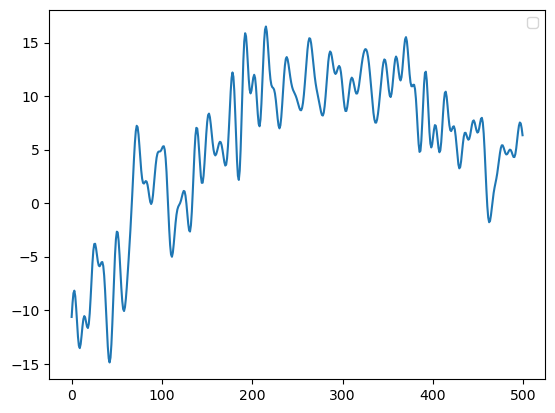

In [ ]:
# plt.plot(referenced[:500,0])
plt.plot(ses_data['eeg']['data'][:500,0])
plt.legend()

C:\Users\pablr\AppData\Local\Temp\ipykernel_2908\1769615410.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(channel_names)
C:\Users\pablr\AppData\Local\Temp\ipykernel_2908\1769615410.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(channel_names)


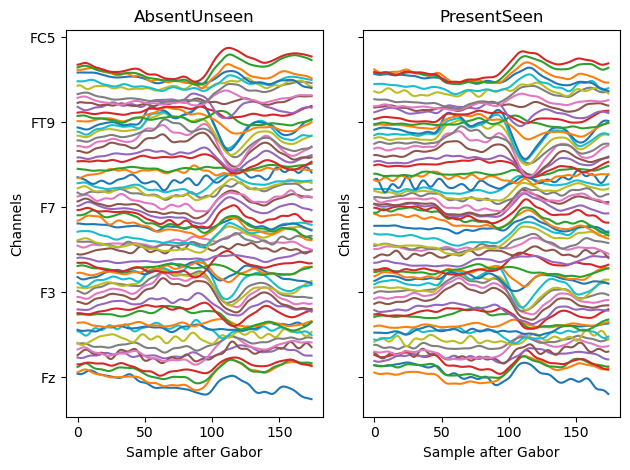

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, tight_layout=True)
waterfall_plot(epochs['PresentUnseen'], ses_data['eeg']['channel_names'], ax=ax1, title='AbsentUnseen')
waterfall_plot(epochs['PresentSeen'], ses_data['eeg']['channel_names'], ax=ax2, title='PresentSeen')

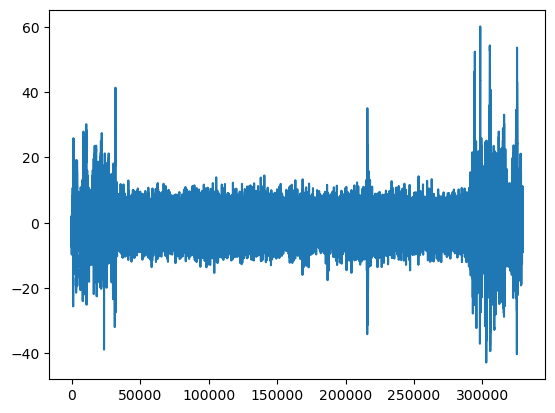

In [ ]:
# Ploteamos un canal para la sesión completa
# plot the complete session, one channel
ch = 27
plt.plot(ses_data['eeg']['data'][:,ch])

Text(0, 0.5, 'Módulo (dB)')

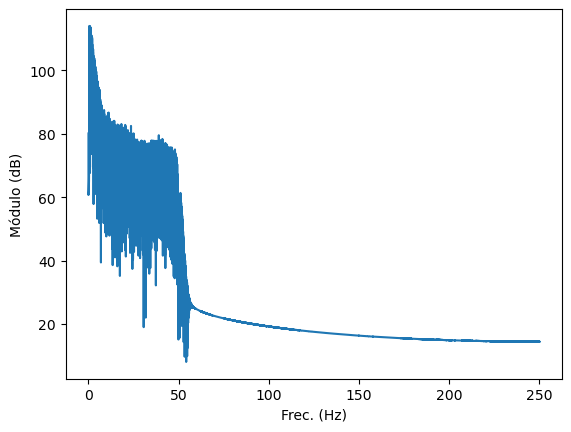

In [ ]:
# Ploteamos la PSD de un canal
# plot PSD for a channel
# ch = np.where(ses_data['eeg']['channel_names'] == 'PO4')[0][0]
ch = 0
X = np.fft.rfft(ses_data['eeg']['data'][:,ch])
freq = np.fft.rfftfreq(ses_data['eeg']['data'][:,ch].size, 1/500)
plt.plot(freq, 20*np.log10(np.abs(X)))
#plt.plot(freq, X)
plt.xlabel('Frec. (Hz)')
plt.ylabel('Módulo (dB)')

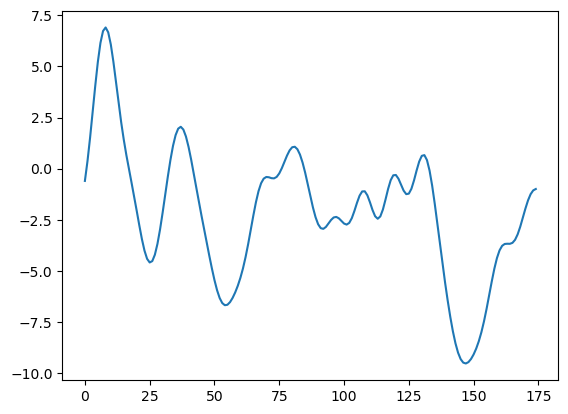

In [ ]:
# Ploteamos un canal para un trial dado
# plot one trial for one channel
ch = 56
trial = 1
plt.plot(epochs['PresentSeen'][ch, :, trial])

Here is where we select the data for training/testing the model.

In [ ]:
# select data from the first session as training set

baseline_range = slice(0, 100)
    
SESSIONS = ['S001']

# Loop over all sessions from the participant
for ses in SESSIONS:
    session_xdf_file = DATA_ROOT.joinpath(f'sub-{SUBJECT}', f'ses-{ses}', 'eeg', f'sub-{SUBJECT}_ses-{ses}_task-Default_run-001_eeg.xdf')
    # print(session_xdf_file)
    ses_data = load_synchronized_eeg_from_xdf(session_xdf_file, 'actiCHamp-21070611', 'EEGPilotMarkerStream')
    # Filtramos la señal pasa-banda y aplicamos filtro de notch para eliminar el ruido de la línea eléctrica
    ses_data = eeg_filtering(ses_data)
    # Referenciamos los datos y aplicamos detrend  (OJO!! El detrending no se puede aplicar en tiempo real)
    ses_data = eeg_referencing(ses_data, ref_channel='FCz', detrend=None)
    # ses_data = eeg_referencing(ses_data, detrend=None)
    # Find the time_stamps for the 'StartGabor' and 'EndGabor' markers
    start_gabor_ts = get_markers_time_stamps(ses_data, 'StartGabor')
    # end_gabor_ts = get_markers_time_stamps(ses_data, 'EndGabor')  Estos nos los necesitamos
    response_ts = get_markers_time_stamps(ses_data, 'EndResponse')  # Time_stamps of the participant keystroke
    # Segment the trials in the EEG stream
    epochs = segment_eeg_trials(ses_data, start_gabor_ts, response_ts)
    # Apply baseline correction to each condition
    for condition in epochs:
        epochs[condition] = baseline_correction(epochs[condition], baseline_range)
    
# Initialize a dictionary to store labels
labels_dict = {}

# Create labels for each condition
for key in epochs.keys():
    labels = np.array([key] * epochs[key].shape[2])
    labels_dict[key] = labels
    
# Concatenate epochs for 'Present' and 'Absent' conditions
x_present = np.concatenate((epochs['PresentSeen'].T, epochs['PresentUnseen'].T), axis=0)  
x_absent = np.concatenate((epochs['AbsentSeen'].T, epochs['AbsentUnseen'].T), axis=0)

# Create corresponding labels
y_present = np.array(['Present'] * x_present.shape[0])
y_absent = np.array(['Absent'] * x_absent.shape[0])

# Combine 'Present' and 'Absent' data and labels
x_train = np.concatenate((x_present, x_absent), axis=0)  
y_train = np.concatenate((y_present, y_absent))  

# Shuffle the training data
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)

x_train = x_train[indices]
y_train = y_train[indices]

# Print the shape of the training data and labels
print(x_train.shape)
print(y_train.shape)

(199, 175, 64)
(199,)


In [16]:
# select data from the second session as testing set
SESSIONS = ['S002']

# Loop over all sessions from the participant
for ses in SESSIONS:
    session_xdf_file = DATA_ROOT.joinpath(f'sub-{SUBJECT}', f'ses-{ses}', 'eeg', f'sub-{SUBJECT}_ses-{ses}_task-Default_run-001_eeg.xdf')
    # print(session_xdf_file)
    ses_data = load_synchronized_eeg_from_xdf(session_xdf_file, 'actiCHamp-21070611', 'EEGPilotMarkerStream')
    # Filtramos la señal pasa-banda y aplicamos filtro de notch para eliminar el ruido de la línea eléctrica
    ses_data = eeg_filtering(ses_data)
    # Referenciamos los datos y aplicamos detrend  (OJO!! El detrending no se puede aplicar en tiempo real)
    ses_data = eeg_referencing(ses_data, ref_channel='FCz', detrend=None)
    # ses_data = eeg_referencing(ses_data, detrend=None)
    # Find the time_stamps for the 'StartGabor' and 'EndGabor' markers
    start_gabor_ts = get_markers_time_stamps(ses_data, 'StartGabor')
    # end_gabor_ts = get_markers_time_stamps(ses_data, 'EndGabor')  Estos nos los necesitamos
    response_ts = get_markers_time_stamps(ses_data, 'EndResponse')  # Time_stamps of the participant keystroke
    # Segment the trials in the EEG stream 
    epochs = segment_eeg_trials(ses_data, start_gabor_ts, response_ts)
    
    for condition in epochs:
        epochs[condition] = baseline_correction(epochs[condition], baseline_range)
    
labels_dict = {}

for key in epochs.keys():
    labels = np.array([key] * epochs[key].shape[2])
    labels_dict[key] = labels

x_present = np.concatenate((epochs['PresentSeen'].T, epochs['PresentUnseen'].T), axis=0)
x_absent = np.concatenate((epochs['AbsentSeen'].T, epochs['AbsentUnseen'].T), axis=0)

y_present = np.array(['Present'] * x_present.shape[0])
y_absent = np.array(['Absent'] * x_absent.shape[0])

x_test = np.concatenate((x_present, x_absent), axis=0)  
y_test = np.concatenate((y_present, y_absent))  

indices = np.arange(x_test.shape[0])
np.random.shuffle(indices)

x_test = x_test[indices]
y_test = y_test[indices]  

print(x_test.shape)
print(y_test.shape)

(299, 141, 64)
(299,)


In [17]:
# find minimal time dimension (both sessions have different times )
min_time_dim = min(x_train.shape[1], x_test.shape[1])

x_train = x_train[:, :min_time_dim, :]
x_test = x_test[:, :min_time_dim, :]

print(x_train.shape)
print(x_test.shape)

(199, 141, 64)
(299, 141, 64)


In [18]:
# transform labels to 1/0
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

0.8193979933110368


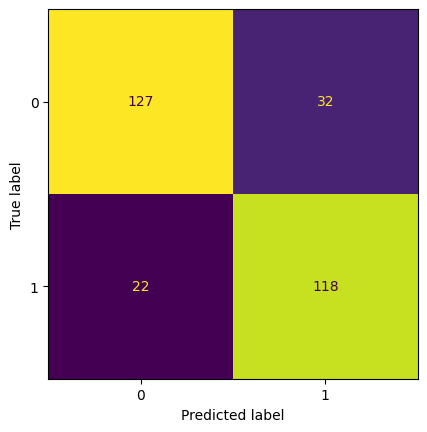

In [19]:
# train and test classifier
# clf = make_pipeline(Vectorizer(), StandardScaler(),
#                    LinearSVC(class_weight='balanced'))

clf = make_pipeline(Vectorizer(), StandardScaler(),
                    LinearDiscriminantAnalysis())

clf.fit(x_train, y_train)

# #  Save full model
# with open('trained_lda.pkl', 'wb') as file:
#     pickle.dump(clf, file)

print(clf.score(x_test, y_test))

y_pred = clf.predict(x_test)

# generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm)
disp.plot(colorbar = False)